# Topic Modelling for Twitter users' descriptions

In this notebook I will try to find similar characteristics of users by analysing users' descriptions.

The assumption for the LDA:
1. I will only analyze users that have =>10 tweets using #banking.
2. I will only analyze users that have tweeted after 2018


In [1]:
import pandas as pd
import feather
import pickle
import matplotlib.pyplot as plt
import os
import re
import string
import numpy as np
import pprint

# matplotlib style
plt.style.use('fivethirtyeight')
# options, figure size:
plt.rcParams['figure.figsize'] = [20, 10]

dataset = input()
path = os.getcwd() +'/Datasets/'+dataset+'/'

banking


In [2]:
df_users = pd.read_feather(path+dataset+'_users18.ftr')

# Select only users that have 10 or more tweets
df_users = df_users[df_users.sum_tweets>9]

# Select relevant columns
df_users = df_users.iloc[:,[1]]

# Remove users that do not provide a description:
df_users = df_users[df_users.description!='']

## 1) Clean the descriptions and create a term-document matrix

### 1.1) Basic text cleaning

In [3]:
# Apply the same cleaning to description as to the text:
def clean_text_round1(text):
    """Initial cleaning I make to the dataset"""
    text = re.sub(r'@[A-Za-z0-9]+','',text) #Removes @mentions
    text = re.sub(r'#','',text) #Removes the '#' symbol
    text = re.sub(r'RT[\s]+', '', text) #Removing RT
    text = re.sub(r'&amp;','',text) #Removes &amp
    text = re.sub(r'https?:\/\/\S+','',text) #Remove the hyper link
    text = re.sub(r'\n','',text) #remove the new line symbol
    text = re.sub(r'\t','',text) #remove the tab symbol
    #Removes the punctuation:
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text) #remove words containing numbers
    text = re.sub(r"[^a-zA-Z0-9]+", " ", text) #Removes special characters except space
    text = re.sub(' +', ' ', text).strip() #Removes trailing white spaces
    text = text.lower() # lowers the text
    text = re.sub(r'\b(\w+)( \1\b)+', r'\1', text) #remove duplicate words

    return text

In [4]:
# Clean the text
df_users['description'] = df_users['description'].apply(clean_text_round1)

# Sample randomly
df_users = df_users.sample(frac=1, random_state=100).reset_index(drop=True)

### 1.2) Create a term-document matrix
First, as I similarly created a document-term matrix for the tweets, I will create a term-document matrix for the description. I will also have to create a corpus containing of all the descriptions.

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text

In [6]:
# Add additional stop words:
add_stop_words = ['account', 'follow', 'tweets', 'tweet', 'twitter']
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

cv = CountVectorizer(stop_words = stop_words)
data_cv = cv.fit_transform(df_users.description)

data_dtm = pd.DataFrame(data_cv.toarray(), 
                        columns = cv.get_feature_names())

#data_dtm['column_names']=categories
#data_dtm.set_index('column_names',inplace=True)

# Create a term-document matrix:
data_dtm = data_dtm.transpose()

## 2) LDA with GenSim

### 2.1) Preparations for the model

In [7]:
from gensim import matutils, models, corpora
from gensim.models.callbacks import PerplexityMetric, ConvergenceMetric, CoherenceMetric
from tqdm import tqdm

import scipy.sparse

In [8]:
import logging
logging.basicConfig(filename='model_callbacks.log',
                    format='%(asctime)s : %(levelname)s : %(message)s',
                    level=logging.NOTSET)

#logging.disable()

In [9]:
# Gensim also requires dictionary of the all terms and their respective
# location in the term-document matrix:
id2word = dict((v,k) for k,v in cv.vocabulary_.items())

# Put the data_dtm to a new gensim format:
# From data_dtm --> sparse matrix --> gensim corpus
sparse_counts = scipy.sparse.csr_matrix(data_dtm)
corpus = matutils.Sparse2Corpus(sparse_counts)

In [10]:
# Set up the callbacks loggers
perplexity_logger = PerplexityMetric(corpus=corpus, logger='shell')
convergence_logger = ConvergenceMetric(logger='shell')
#coherence_cv_logger = CoherenceMetric(corpus=corpus, logger='shell',
#                                      coherence = 'c_v', texts = documents)

### 2.2) Running the model with different parameters and evaluating the model

In [11]:
# Try different iterations:
iterations = [50,100]

# Change passes also:
passes = 100

# And number of topics:
topics = 4

for iteration in iterations:
    # Add text to logger to indicate new model:
    logging.debug(f'Start of model: {iteration} iterations')
    
    # Create the model
    model = models.LdaModel(corpus=corpus,
                           id2word=id2word,
                           num_topics=topics,
                           eval_every=20,
                           passes=passes,
                           iterations=iteration,
                           random_state=100,
                           callbacks=[convergence_logger,perplexity_logger])
    
    # Add text to logger to indicate the of the model:
    logging.debug(f'End of model: {iteration} iterations')
    
    # Also, save the models:
    if not os.path.exists(f"lda_{iteration}i{passes}p/"):
        os.makedirs(f"lda_{iteration}i{passes}p/")
        
    model.save(f"lda_{iteration}i{passes}p/lda_{iteration}i{passes}p_{topics}top.model")

In [12]:
iterations = [50,100]
passes = 100
topics = 4

all_metrics = pd.DataFrame()

for iteration in tqdm(iterations):
    model = models.LdaModel.load(f"lda_{iteration}i{passes}p/lda_{iteration}i{passes}p_{topics}top.model")
    df = pd.DataFrame.from_dict(model.metrics)
    
    #df['docs_converged'] = find_doc_convergence(5, iteration, "model_callbacks.log")
    df['iterations'] = iteration
    df['topics'] = 5
    
    df = df.reset_index().rename(columns={'index': 'pass_num'})
    
    all_metrics = pd.concat([all_metrics, df])

100%|██████████| 2/2 [00:05<00:00,  2.53s/it]


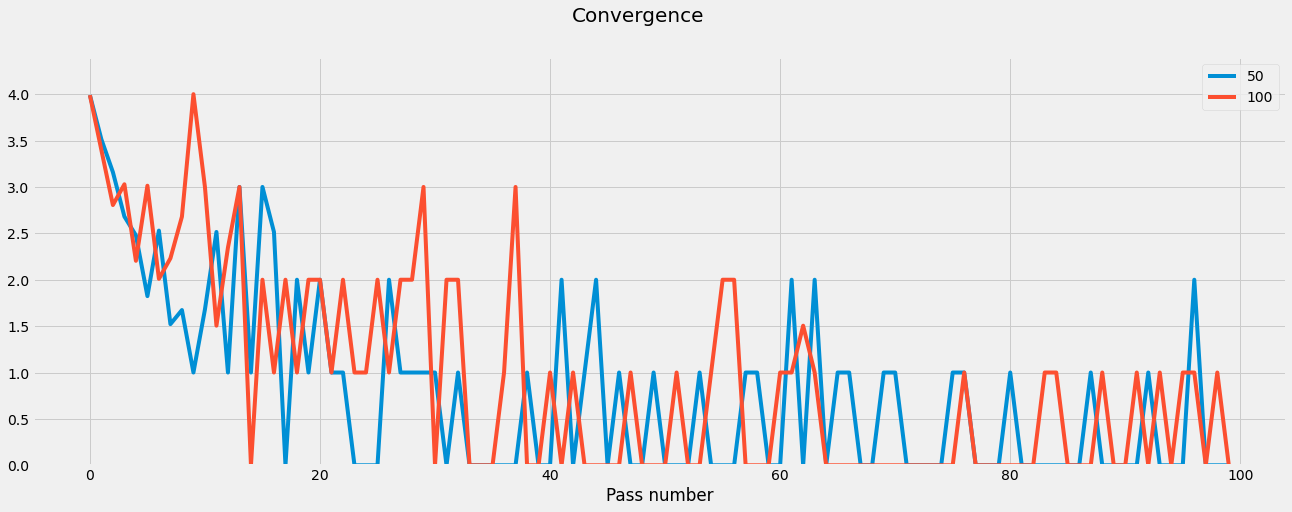

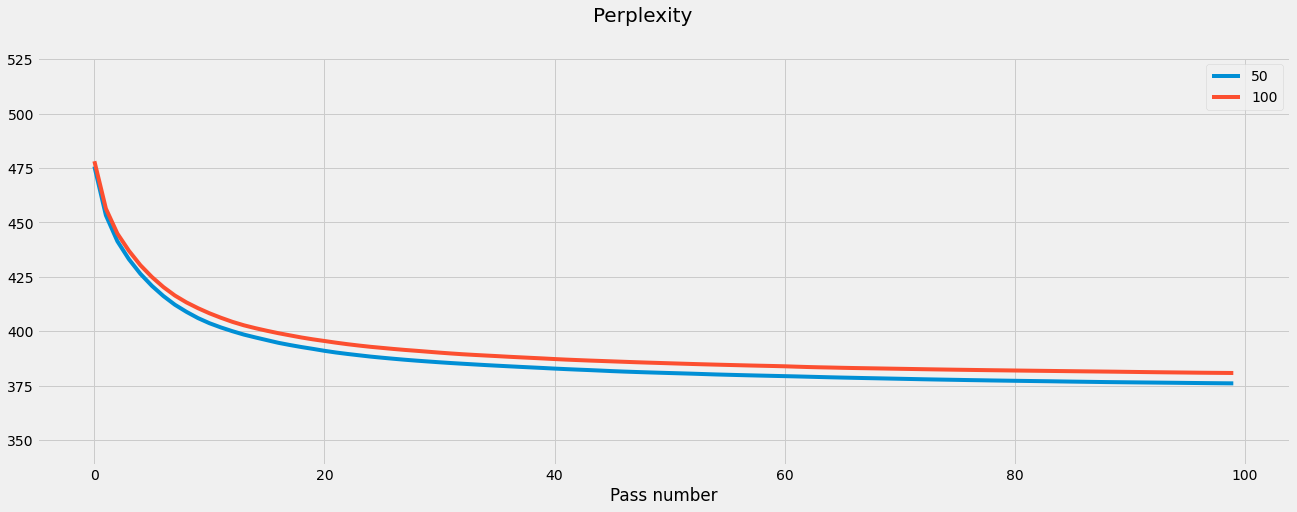

In [13]:
for metric in ['Convergence', 'Perplexity']:
    
    fig,axs = plt.subplots(1,1,figsize=(20,7))
    
    for i, topic_number in enumerate([5]):
        filtered_topics = all_metrics[all_metrics['topics']==topic_number]
        for label,df in filtered_topics.groupby(['iterations']):
            df.plot(x='pass_num', y=metric, ax=axs, label=label)
            
        axs.set_xlabel(f"Pass number")
        axs.legend()
        axs.set_ylim([all_metrics[metric].min() * 0.9, all_metrics[metric].max() * 1.1])
        
    fig.suptitle(metric, fontsize=20)

In [14]:
np.random.seed(100)
lda = models.LdaModel(corpus=corpus,
                            id2word=id2word,
                            num_topics=4,
                            eval_every=20,
                            passes=50,
                            iterations=100,
                            random_state=100)
lda.print_topics()

[(0,
  '0.011*"digital" + 0.009*"business" + 0.009*"solutions" + 0.008*"data" + 0.006*"customer" + 0.006*"helping" + 0.006*"platform" + 0.006*"experience" + 0.006*"help" + 0.006*"people"'),
 (1,
  '0.009*"bank" + 0.008*"jobs" + 0.007*"job" + 0.007*"law" + 0.006*"years" + 0.005*"uk" + 0.005*"legal" + 0.005*"firm" + 0.005*"recruitment" + 0.005*"career"'),
 (2,
  '0.016*"fintech" + 0.013*"digital" + 0.013*"marketing" + 0.012*"views" + 0.011*"ai" + 0.010*"innovation" + 0.009*"tech" + 0.007*"founder" + 0.007*"iot" + 0.007*"opinions"'),
 (3,
  '0.027*"news" + 0.022*"business" + 0.020*"financial" + 0.018*"services" + 0.016*"banking" + 0.011*"global" + 0.009*"finance" + 0.008*"leading" + 0.008*"industry" + 0.008*"management"')]

In [15]:
from gensim.test.utils import datapath

In [16]:
# Save the model
temp_file=datapath('model>10_2')
lda.save(temp_file)

### 2.3) Making inference and checking the validity of topics

In [17]:
from gensim.test.utils import datapath
from gensim.corpora.dictionary import Dictionary

In [18]:
# Load up the main model:
temp_file = datapath('model>10_2')
lda2 = models.LdaModel.load(temp_file)

In [19]:
pprint.pprint(lda2.show_topics())

[(0,
  '0.011*"digital" + 0.009*"business" + 0.009*"solutions" + 0.008*"data" + '
  '0.006*"customer" + 0.006*"helping" + 0.006*"platform" + 0.006*"experience" '
  '+ 0.006*"help" + 0.006*"people"'),
 (1,
  '0.009*"bank" + 0.008*"jobs" + 0.007*"job" + 0.007*"law" + 0.006*"years" + '
  '0.005*"uk" + 0.005*"legal" + 0.005*"firm" + 0.005*"recruitment" + '
  '0.005*"career"'),
 (2,
  '0.016*"fintech" + 0.013*"digital" + 0.013*"marketing" + 0.012*"views" + '
  '0.011*"ai" + 0.010*"innovation" + 0.009*"tech" + 0.007*"founder" + '
  '0.007*"iot" + 0.007*"opinions"'),
 (3,
  '0.027*"news" + 0.022*"business" + 0.020*"financial" + 0.018*"services" + '
  '0.016*"banking" + 0.011*"global" + 0.009*"finance" + 0.008*"leading" + '
  '0.008*"industry" + 0.008*"management"')]


In [20]:
# Create a list of topics
list_of_topics = ['Finance/Banking/Business', 'Fintech', 'News/Jobs', 'Personal/Professionals']
list_of_topics

['Finance/Banking/Business', 'Fintech', 'News/Jobs', 'Personal/Professionals']

In [21]:
# Create a new gensim dictionary object from the corpus of words
dictionary = Dictionary.from_corpus(corpus)

# Assign all descriptions to topics
all_topics = lda2.get_document_topics(corpus, per_word_topics=True)

In [22]:
# Result comes in as a unsorted tuple (Group, Probability)
# This function sorts them
def Sort_Tuple(tup):
    tup.sort(key = lambda x: x[1], reverse=True)
    return tup

In [23]:
# Count the freqency of topics:
topic_count = []
for i in range(len(all_topics)):
    topic_count.append(Sort_Tuple(all_topics[i][0])[0][0])

In [24]:
for i in range(len(list_of_topics)):
    print(list_of_topics[i],'-',topic_count.count(i))

Finance/Banking/Business - 4618
Fintech - 2777
News/Jobs - 5773
Personal/Professionals - 5465


In [25]:
for i in range(10):
    print('New Document:')
    print('Assignment, Probability:',Sort_Tuple(all_topics[i][0])[0])
    print('Topic:', list_of_topics[Sort_Tuple(all_topics[i][0])[0][0]])
    print('Document:',df_users.description[i])
    print('')

New Document:
Assignment, Probability: (3, 0.58243346)
Topic: Personal/Professionals
Document: hro research director at nelsonhall the global bpo analyst and advisory firm i specialize in rpo learning development bpo payroll and talent management

New Document:
Assignment, Probability: (1, 0.46624976)
Topic: Fintech
Document: reflecting the innovative dedicated and resultsfocus of asia pacific culture in business

New Document:
Assignment, Probability: (3, 0.9509008)
Topic: Personal/Professionals
Document: in europe gallup focuses on behavioraleconomics social survey research data analysis on paneu or global level retweets do not imply endorsement

New Document:
Assignment, Probability: (1, 0.80523705)
Topic: Fintech
Document: pirate des hautesalpes today in lemans accompagne les hommes et les organisations leurs id es leurs projets et leurs transformations

New Document:
Assignment, Probability: (0, 0.5889633)
Topic: Finance/Banking/Business
Document: world leader in customer journey 